# B.1 Fitting a GP with Pyro

1. Using NUTS to sample from the posterior $p(\theta|\mathcal{D} )$:

In [ ]:
!pip install pyro-ppl
#!pip install pyro-ppl --upgrade
from google.colab import files
#drive.mount('/content/gdrive')
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDelta
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import lognorm

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0)

directory = os.getcwd()

def f(x):
  return np.sin(20*x) + 2*np.cos(14*x) - 2*np.sin(6*x)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Define the dataset
X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
Y_noscale = f(X)
Y = (Y_noscale - Y_noscale.mean()) / Y_noscale.std() #scaling

kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(loc=-1, scale=1))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(loc=0, scale=2))
gpr = gp.models.GPRegression(X, Y, kernel, noise=torch.tensor(0.0001))

hmc_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=250, num_chains=2, warmup_steps=1000)
mcmc.run()


/usr/local/lib/python3.8/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [1]: 100%|██████████| 1250/1250 [00:28, 44.27it/s, step size=6.00e-01, acc. prob=0.845]


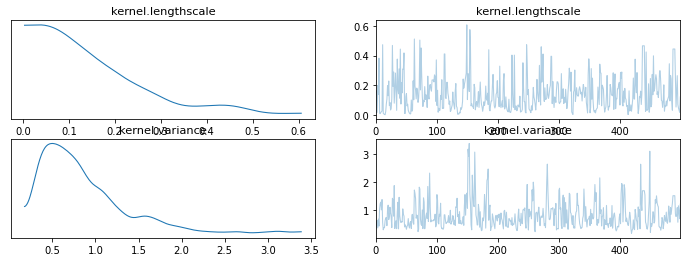

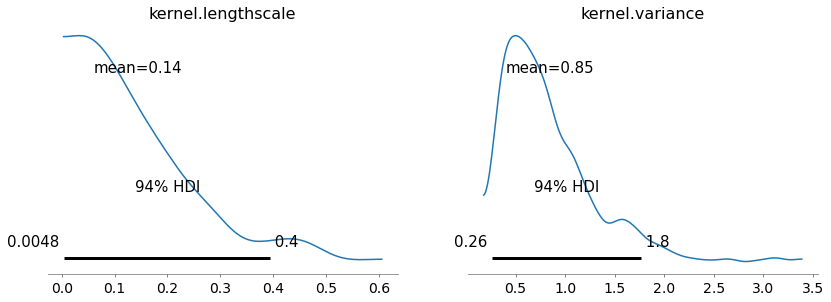

<ipython-input-37-d4742576a68b>:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10)


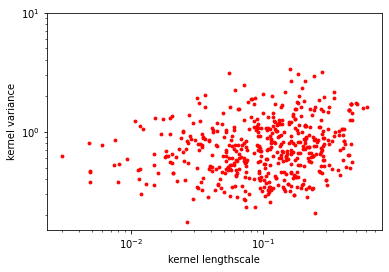

In [ ]:
# Plotting schemes
samples = mcmc.get_samples()
az.plot_trace(samples)
plt.show()

az.plot_posterior(samples)
plt.show()

lengthscale = samples["kernel.lengthscale"]
variance = samples["kernel.variance"]
plt.scatter(lengthscale, variance,
            s=8,
            color="red")
plt.xlabel("kernel lengthscale")
plt.ylabel("kernel variance")
plt.xscale("log")
plt.yscale("log")
plt.ylim(0, 10)
plt.show()

#print(lengthscale.size())


2. Checking the quality of the MCMC sampling

In [ ]:
data = az.from_pyro(mcmc)
summary = az.summary(data) #ESS, r-hat
print(summary) # because we only used one chain, r_hat cannot be evauated.

## Things for the best model:
# High ESS: this means that the generated samples are less correlated (and that is what we want) --
# we would like multichain to be >400 for four chains (as on slides)
# r_hat around 1: this means that the chains have converged
# trace plots: we should see some sort of convergence

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.144  0.115   0.005    0.395      0.008    0.006   
kernel.variance     0.847  0.500   0.260    1.765      0.038    0.029   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     165.0     223.0   1.01  
kernel.variance        231.0     296.0   1.00  


3. Use the obtained MCMC samples from the posterior to obtain estimates of mean $m(x^*)$ and variance $v(x^*)$ of $p(y^*|x^*, \mathcal{D})$ at a point $x^* \in [-1,1]$.

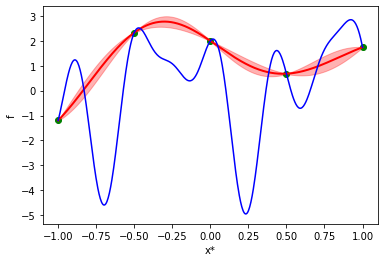

In [ ]:
X_test = torch.linspace(-1, 1, 500)
f_X_test = f(X_test)

#f_loc, f_cov = gpr(X_test, full_cov=True)
y_star_mean_scaled, y_star_var_scaled = gpr(X_test, full_cov=True) #get the sample
y_star_mean = y_star_mean_scaled.detach().numpy() * Y_noscale.std().detach().numpy() + Y_noscale.mean().detach().numpy() # unscaling
y_star_var = y_star_var_scaled.diag() * Y_noscale.std()**2 # unscaling
y_star_sd = y_star_var.sqrt().detach().numpy()  # standard deviation at each input point x
X_test = X_test.detach().numpy()


def plotter(X_test,
            f_X_test,
            y_star_mean,
            y_star_sd,
            X_p = [],
            y_p = [],
            legend = "no"):
  plt.plot(X_test, y_star_mean, "r", lw=2, 
           color="red", label="$m(x^*)$ with\nuncertainty")  # plot the mean
  plt.fill_between(X_test,  # plot the two-sigma uncertainty about the mean
                  y_star_mean - 2 * y_star_sd,
                  y_star_mean + 2 * y_star_sd,
                  color="red", alpha=0.3)
  plt.plot(X_test, f_X_test, color="blue", label="$f(x^*)$")
  plt.scatter(X, Y_noscale, color="green", label="$\mathcal{D}$")
  plt.xlabel("x*")
  plt.ylabel("f")
  if len(X_p) != 0:
    plt.scatter(X_p, y_p, color="orange", label="$(x_p^*, f(x_p^*))$")

  if legend == "yes":
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plotter(X_test, f_X_test, y_star_mean, y_star_sd)
plt.show()

# :DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD

# B.2 Bayesian Optimization

1. Plots for k=0,5,10.

Sample: 100%|██████████| 201/201 [00:06, 32.24it/s, step size=6.20e-01, acc. prob=0.333]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

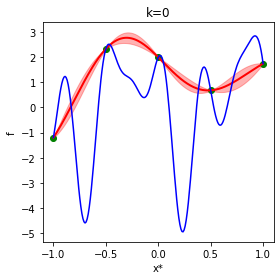

In [ ]:
# k=0
warmups = 200
X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
Y_noscale = f(X)
Y = (Y_noscale - Y_noscale.mean()) / Y_noscale.std() #scaling
X_test = torch.linspace(-1, 1, 200)
f_X_test = f(X_test)

kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(loc=-1, scale=1))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(loc=0, scale=2))
gpr = gp.models.GPRegression(X, Y, kernel, noise=torch.tensor(0.0001))

hmc_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=1, num_chains=1, warmup_steps=warmups)
mcmc.run()


y_star_mean_scaled, y_star_var_scaled = gpr(X_test, full_cov=True) #get the sample
y_star_mean = y_star_mean_scaled.detach().numpy() * Y_noscale.std().detach().numpy() + Y_noscale.mean().detach().numpy() # unscaling
y_star_var = y_star_var_scaled.diag() * Y_noscale.std()**2 # unscaling
y_star_sd = y_star_var.sqrt().detach().numpy()  # standard deviation at each input point x
X_test = X_test.detach().numpy()

plt.figure(figsize=(4,4))
plotter(X_test, f_X_test, y_star_mean, y_star_sd)
plt.title("k=0")
plt.tight_layout()
plt.savefig("k0.png")
files.download("k0.png")
plt.show()



0


Sample: 100%|██████████| 201/201 [00:06, 30.22it/s, step size=4.68e-01, acc. prob=0.664]


tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
1


Sample: 100%|██████████| 201/201 [00:06, 30.18it/s, step size=4.95e-01, acc. prob=0.972]


tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
2


Sample: 100%|██████████| 201/201 [00:05, 39.70it/s, step size=5.69e-01, acc. prob=0.960]


tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
3


Sample: 100%|██████████| 201/201 [00:07, 27.31it/s, step size=6.73e-01, acc. prob=0.977]


tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
4


Sample: 100%|██████████| 201/201 [00:06, 32.40it/s, step size=7.68e-01, acc. prob=0.241]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

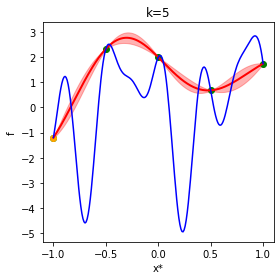

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
5


Sample: 100%|██████████| 201/201 [00:05, 33.74it/s, step size=7.97e-01, acc. prob=0.280]


tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
6


Sample: 100%|██████████| 201/201 [00:05, 34.75it/s, step size=2.95e-01, acc. prob=0.888]


tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
7


Sample: 100%|██████████| 201/201 [00:05, 33.99it/s, step size=5.07e-01, acc. prob=1.000]


tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
8


Sample: 100%|██████████| 201/201 [00:06, 31.61it/s, step size=4.00e-01, acc. prob=0.979]


tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
9


Sample: 100%|██████████| 201/201 [00:06, 31.67it/s, step size=4.16e-01, acc. prob=0.845]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

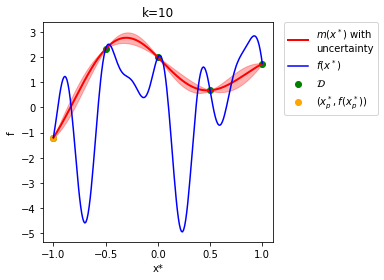

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
10


Sample: 100%|██████████| 201/201 [00:06, 31.59it/s, step size=6.16e-01, acc. prob=0.926]

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])


In [ ]:
T = 11

X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
Y_noscale = f(X)
X_test = torch.linspace(-1, 1, 200)
f_X_test = f(X_test)

all_X_p = []
all_Y_p = []

for i in range(T):
  print(i)
  Y = (Y_noscale - Y_noscale.mean()) / Y_noscale.std() #scaling

  #fit the model (sample f*)
  kernel = gp.kernels.RBF(input_dim=1)
  kernel.variance = pyro.nn.PyroSample(dist.LogNormal(loc=-1, scale=1))
  kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(loc=0, scale=2))
  gpr = gp.models.GPRegression(X, Y, kernel, noise=torch.tensor(0.0001))

  hmc_kernel = pyro.infer.NUTS(gpr.model)
  mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=1, num_chains=1, warmup_steps=warmups)
  mcmc.run()
  
  y_star_mean_scaled, y_star_var_scaled = gpr(X_test, full_cov=True) #get the sample
  y_star_mean = y_star_mean_scaled.detach().numpy() * Y_noscale.std().detach().numpy() + Y_noscale.mean().detach().numpy() # unscaling
  y_star_var = y_star_var_scaled.diag() * Y_noscale.std()**2 # unscaling
  y_star_sd = y_star_var.sqrt().detach().numpy()  # standard deviation at each input point x

  #find p
  p_pos = np.argmin(y_star_mean)
  X_p = X_test[p_pos]
  all_X_p = np.unique(np.append(all_X_p, X_p))
  all_Y_p = np.unique(np.append(all_Y_p, f(X_p)))

  #X_test = X_test.detach().numpy()

  X = torch.tensor(np.unique(np.append(X, X_p)))
  Y_noscale = f(X)

  if i==4:
    plt.figure(figsize=(4,4))
    plotter(X_test, f_X_test, y_star_mean, y_star_sd, all_X_p, all_Y_p)
    plt.title("k=5")
    plt.tight_layout()
    plt.savefig("k5.png")
    files.download("k5.png")
    plt.show()

  if i==9:
    plt.figure(figsize=(5.5,4))
    plotter(X_test, f_X_test, y_star_mean, y_star_sd, all_X_p, all_Y_p, legend="yes")
    plt.title("k=10")
    plt.tight_layout()
    plt.savefig("k10.png")
    files.download("k10.png")
    plt.show()

  print(X)


2. :D

3. Better way to select new points

Sample: 100%|██████████| 201/201 [00:09, 21.29it/s, step size=5.33e-01, acc. prob=0.994]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

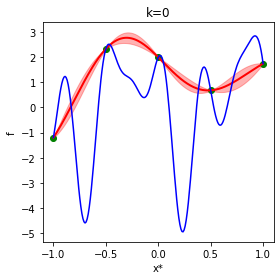

In [ ]:
# k=0
X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
Y_noscale = f(X)
Y = (Y_noscale - Y_noscale.mean()) / Y_noscale.std() #scaling
X_test = torch.linspace(-1, 1, 200)
f_X_test = f(X_test)

kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(loc=-1, scale=1))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(loc=0, scale=2))
gpr = gp.models.GPRegression(X, Y, kernel, noise=torch.tensor(0.0001))

hmc_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=1, num_chains=1, warmup_steps=warmups)
mcmc.run()


y_star_mean_scaled, y_star_var_scaled = gpr(X_test, full_cov=True) #get the sample
y_star_mean = y_star_mean_scaled.detach().numpy() * Y_noscale.std().detach().numpy() + Y_noscale.mean().detach().numpy() # unscaling
y_star_var = y_star_var_scaled.diag() * Y_noscale.std()**2 # unscaling
y_star_sd = y_star_var.sqrt().detach().numpy()  # standard deviation at each input point x

plt.figure(figsize=(4,4))
plotter(X_test, f_X_test, y_star_mean, y_star_sd)
plt.title("k=0")
plt.tight_layout()
plt.savefig("k0_third.png")
files.download("k0_third.png")
plt.show()



0


Sample: 100%|██████████| 201/201 [00:05, 35.15it/s, step size=4.50e-01, acc. prob=0.996]


X_min= tensor(-1.) , Y_min= tensor(-1.1983)
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065])
1


Sample: 100%|██████████| 201/201 [00:08, 23.55it/s, step size=3.93e-01, acc. prob=0.156]


X_min= tensor(-1.) , Y_min= tensor(-1.1983)
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683])
2


Sample: 100%|██████████| 201/201 [00:11, 17.06it/s, step size=2.74e-01, acc. prob=0.685]


X_min= tensor(-0.8392) , Y_min= tensor(0.3512)
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683, -0.8392,  0.2663])
3


Sample: 100%|██████████| 201/201 [00:07, 27.75it/s, step size=4.50e-01, acc. prob=0.994]


X_min= tensor(0.2864) , Y_min= tensor(-3.7968)
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683, -0.8392,  0.2663,  0.2864,  0.7990])
4


Sample: 100%|██████████| 201/201 [00:12, 16.75it/s, step size=3.45e-01, acc. prob=0.966]


X_min= tensor(0.2663) , Y_min= tensor(-4.4816)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

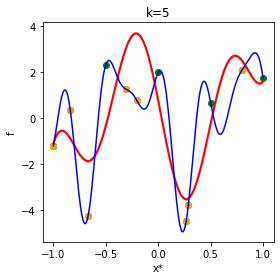

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683, -0.8392,  0.2663,  0.2864,  0.7990,  0.2663, -0.2060])
5


Sample: 100%|██████████| 201/201 [00:06, 28.87it/s, step size=5.13e-01, acc. prob=0.946]


X_min= tensor(0.2563) , Y_min= tensor(-4.7188)
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683, -0.8392,  0.2663,  0.2864,  0.7990,  0.2663, -0.2060,  0.2563,
         0.7487])
6


Sample: 100%|██████████| 201/201 [00:06, 30.76it/s, step size=6.61e-01, acc. prob=0.954]


X_min= tensor(0.2563) , Y_min= tensor(-4.7188)
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683, -0.8392,  0.2663,  0.2864,  0.7990,  0.2663, -0.2060,  0.2563,
         0.7487,  0.2563, -0.2261])
7


Sample: 100%|██████████| 201/201 [00:06, 31.72it/s, step size=9.35e-01, acc. prob=0.737]


X_min= tensor(0.2563) , Y_min= tensor(-4.7188)
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683, -0.8392,  0.2663,  0.2864,  0.7990,  0.2663, -0.2060,  0.2563,
         0.7487,  0.2563, -0.2261,  0.2563,  0.7387])
8


Sample: 100%|██████████| 201/201 [00:06, 32.73it/s, step size=9.93e-01, acc. prob=0.967]


X_min= tensor(0.2563) , Y_min= tensor(-4.7188)
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683, -0.8392,  0.2663,  0.2864,  0.7990,  0.2663, -0.2060,  0.2563,
         0.7487,  0.2563, -0.2261,  0.2563,  0.7387,  0.2563,  0.7387])
9


Sample: 100%|██████████| 201/201 [00:07, 28.40it/s, step size=7.27e-01, acc. prob=0.999]


X_min= tensor(0.2563) , Y_min= tensor(-4.7188)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

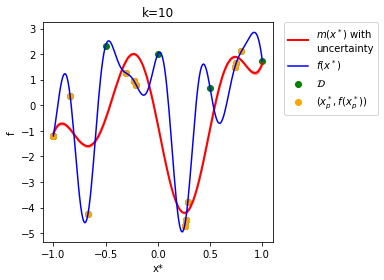

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -0.3065, -1.0000,
        -0.6683, -0.8392,  0.2663,  0.2864,  0.7990,  0.2663, -0.2060,  0.2563,
         0.7487,  0.2563, -0.2261,  0.2563,  0.7387,  0.2563,  0.7387,  0.2563,
        -0.2261])


In [ ]:
T = 10

X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
Y_noscale = f(X)
X_test = torch.linspace(-1, 1, 200)
f_X_test = f(X_test)

all_X_p = []
all_Y_p = []

for i in range(T):
  print(i)
  Y = (Y_noscale - Y_noscale.mean()) / Y_noscale.std() #scaling

  #fit the model (sample f*)
  kernel = gp.kernels.RBF(input_dim=1)
  kernel.variance = pyro.nn.PyroSample(dist.LogNormal(loc=-1, scale=1))
  kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(loc=0, scale=2))
  gpr = gp.models.GPRegression(X, Y, kernel, noise=torch.tensor(0.0001))

  hmc_kernel = pyro.infer.NUTS(gpr.model)
  mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=1, num_chains=1, warmup_steps=warmups)
  mcmc.run()

  y_star_mean_scaled, y_star_var_scaled = gpr(X_test, full_cov=True) #get the sample
  y_star_mean = y_star_mean_scaled.detach().numpy() * Y_noscale.std().detach().numpy() + Y_noscale.mean().detach().numpy() # unscaling
  y_star_var = y_star_var_scaled.diag() * Y_noscale.std()**2 # unscaling
  y_star_sd = y_star_var.sqrt().detach().numpy()  # standard deviation at each input point x

  #find p
  #X_middlepoints = (X[1:] + X[:-1])/2
  p_pos = np.argmin(y_star_mean)
  X_p = X_test[p_pos]
  print("X_min=", X_p, ", Y_min=", f(X_p))
  p_pos_max = np.argmax(y_star_mean)
  X_p_max = X_test[p_pos_max]
  p_mode = np.where(y_star_mean == np.median(y_star_mean))[0]
  X_p_mode = X_test[p_mode]


  all_X_p = np.append(np.append(np.append(all_X_p, X_p), X_p_max), X_p_mode)
  all_Y_p = np.append(np.append(np.append(all_Y_p, f(X_p)), f(X_p_max)), f(X_p_mode))

  #X_test = X_test.detach().numpy()

  X = torch.tensor(np.append(np.append(np.append(X, X_p), X_p_max), X_p_mode))
  Y_noscale = f(X)

  if i==4:
    plt.figure(figsize=(4,4))
    plotter(X_test, f_X_test, y_star_mean, y_star_sd, all_X_p, all_Y_p)
    plt.title("k=5")
    plt.tight_layout()
    plt.savefig("k5_third.png")
    files.download("k5_third.png")
    plt.show()

  if i==9:
    plt.figure(figsize=(5.5,4))
    plotter(X_test, f_X_test, y_star_mean, y_star_sd, all_X_p, all_Y_p, legend="yes")
    plt.title("k=10")
    plt.tight_layout()
    plt.savefig("k10_third.png")
    files.download("k10_third.png")
    plt.show()

  if i==14:
    plotter(X_test, f_X_test, y_star_mean, y_star_sd, all_X_p, all_Y_p)
    plt.title("k=15")
    plt.tight_layout()
    plt.savefig("k15_third.png")
    files.download("k15_third.png")
    plt.show()

  print(X)
